# Validation, regularisation and callbacks

In [1]:
import tensorflow as tf
print(tf.__version__)

2025-11-26 18:34:26.168205: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-26 18:34:26.235243: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-26 18:34:27.398259: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.20.0


 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### 3. Batch normalisation
 #### [4. Introduction to callbacks](#coding_tutorial_3)
 #### 5. Using logs dictionary in callbacks
 #### [6. Early stopping / patience](#coding_tutorial_4)
 #### 7. Additional callback arguments

***
<a id="coding_tutorial_1"></a>
# 01 Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
print(diabetes["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [3]:
# Save the input and target variables

print(diabetes.keys())
data = diabetes['data']
targets = diabetes['target']

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])


In [4]:
# Normalise the target data (this will make clearer training curves)

targets_mean = targets.mean()
targets_std = targets.std()
normed_targets = (targets - targets_mean) / targets_std

In [5]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

data_train, data_test, targets_train, targets_test = train_test_split(
    data, normed_targets, test_size=0.1, random_state=863
)

print(f"Data train shape: {data_train.shape}")
print(f"Data test shape: {data_test.shape}")

print(f"Targets train shape: {targets_train.shape}")
print(f"Targets test shape: {targets_test.shape}")

Data train shape: (397, 10)
Data test shape: (45, 10)
Targets train shape: (397,)
Targets test shape: (45,)


#### Train a feedforward neural network model

In [7]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    """
    Build and return a compiled Keras Sequential model for regression.
    With three hidden layers, each with 64 neurons and ReLU activation.
    1 output neuron for regression.

    This models is overly complex for this dataset, and is likely to overfit.
    64 neurons is also likely too many for this dataset.
    """
    model = Sequential()

    model.add(Dense(64, activation='relu', input_shape=(data_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # Single output for regression

    return model

model = get_model()

/home/nvidia/miniforge3/envs/rapids-25.10-cuda12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1764203668.879162  210888 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [8]:
# Print the model summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model

def compile_(model):
    """
    Compile the Keras model with Adam optimizer, MSE loss and MAE and MSE metrics.
    """

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss_function = 'mse'
    metrics = ['mae', 'mse']

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

compile_(model)

In [12]:
# Train the model, with some of the data reserved for validation

def fit_(model):
    """
    Fit the Keras model on the training data, with 20% reserved for validation.
    Train for 500 epochs with a batch size of 64.
    """
    history = model.fit(
        data_train,
        targets_train,
        validation_split=0.2,
        epochs=500,
        batch_size=64,
        verbose=2
    )
    return history

history = fit_(model)

Epoch 1/500


2025-11-26 18:34:30.735394: I external/local_xla/xla/service/service.cc:163] XLA service 0x79e33800ad20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-26 18:34:30.735573: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-26 18:34:30.759235: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-26 18:34:30.958761: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-26 18:34:30.975660: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-26 18:34:30.

5/5 - 8s - 2s/step - loss: 1.0105 - mae: 0.8541 - mse: 1.0105 - val_loss: 0.9525 - val_mae: 0.8540 - val_mse: 0.9525
Epoch 2/500
5/5 - 0s - 30ms/step - loss: 0.9848 - mae: 0.8441 - mse: 0.9848 - val_loss: 0.9193 - val_mae: 0.8376 - val_mse: 0.9193
Epoch 3/500
5/5 - 0s - 25ms/step - loss: 0.9508 - mae: 0.8292 - mse: 0.9508 - val_loss: 0.8772 - val_mae: 0.8173 - val_mse: 0.8772
Epoch 4/500
5/5 - 0s - 26ms/step - loss: 0.9092 - mae: 0.8122 - mse: 0.9092 - val_loss: 0.8189 - val_mae: 0.7891 - val_mse: 0.8189
Epoch 5/500
5/5 - 0s - 25ms/step - loss: 0.8537 - mae: 0.7871 - mse: 0.8537 - val_loss: 0.7557 - val_mae: 0.7558 - val_mse: 0.7557
Epoch 6/500
5/5 - 0s - 28ms/step - loss: 0.7870 - mae: 0.7569 - mse: 0.7870 - val_loss: 0.6753 - val_mae: 0.7108 - val_mse: 0.6753
Epoch 7/500
5/5 - 0s - 29ms/step - loss: 0.7072 - mae: 0.7168 - mse: 0.7072 - val_loss: 0.5995 - val_mae: 0.6594 - val_mse: 0.5995
Epoch 8/500
5/5 - 0s - 21ms/step - loss: 0.6256 - mae: 0.6705 - mse: 0.6256 - val_loss: 0.5290 - 

In [13]:
history_dict = history.history
print(history_dict.keys())  # Print available metrics

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


In [14]:
# Evaluate the model on the test set

def evaluate_(model):
    """
    Evaluate the Keras model on the test data.
    Print the loss, MAE and MSE.
    """
    evaluation = model.evaluate(data_test, targets_test, verbose=2)
    print(evaluation)
    print(f"Test set loss: {evaluation[0]}")
    print(f"Test set MAE: {evaluation[1]}")
    print(f"Test set MSE: {evaluation[2]}")   

In [15]:
evaluate_(model)

2/2 - 1s - 428ms/step - loss: 1.1684 - mae: 0.7904 - mse: 1.1684
[1.168446660041809, 0.7903942465782166, 1.168446660041809]
Test set loss: 1.168446660041809
Test set MAE: 0.7903942465782166
Test set MSE: 1.168446660041809


#### Plot the learning curves

In [16]:
import matplotlib.pyplot as plt

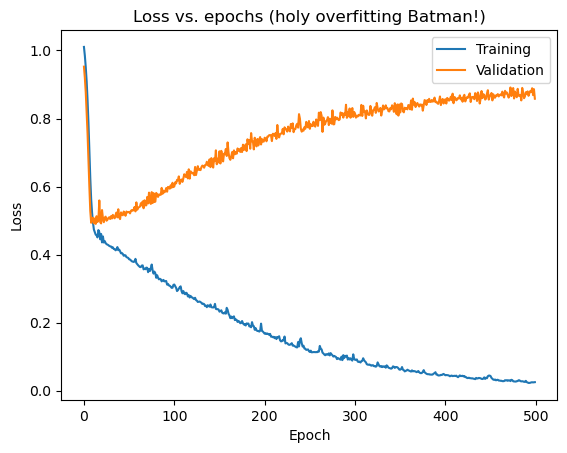

In [17]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs (holy overfitting Batman!)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
# 02 Model regularisation

$L2$ regularisation (weight decay) adds a penalty to the loss function based on the size of the weights. This encourages the model to keep weights small, which can help prevent overfitting.
$L1$ regularisation adds a penalty based on the absolute values of the weights, which can encourage sparsity in the model weights.  
Remember that $L2$ converges assymptotically to zero, whereas $L1$ can converge to exactly zero.

Dropout randomly sets randomly a fraction (required argument) of the input units to 0 at each update during training time, which helps prevent overfitting by making the network less sensitive to specific weights. For example, a dropout rate of 0.2 means that every weight has a 20% chance of being ignored, $w_i^{[t]} = 0$ *during only at the* **training** *update*, which converges to 20% of the weights being set to 0 during each **training** update. The dropout can be seen as a Bernoulli sampling proces, with VAIID probability p = dropout rate.

#### Adding regularisation with weight decay and dropout

In [18]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [19]:
# Build the model with regularisation

def get_model_with_regularisation(weight_l1=0.005, weight_l2=0.001, bias_l2=0.001, dropout_rate=0.2):

    model = Sequential()

    # regularizer = regularizers.l2(0.001)
    # regularizer = regularizers.l1(0.005)
    weight_r = regularizers.l1_l2(l1=weight_l1, l2=weight_l2)

    # Include bias regularization as well
    bias_r = regularizers.l2(bias_l2)

    dropout_rate = dropout_rate

    model.add(Dense(64, activation='relu', kernel_regularizer=weight_r, bias_regularizer=bias_r, input_shape=(data_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=weight_r, bias_regularizer=bias_r))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=weight_r, bias_regularizer=bias_r))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Single output for regression

    return model

In [20]:
# Re-build the model with weight decay and dropout layers

model_regularised = get_model_with_regularisation()

In [21]:
# Print the model summary

model_regularised.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Compile the model

compile_(model_regularised)

In [23]:
# Train the model, with some of the data reserved for validation

history_regularised = fit_(model_regularised)

Epoch 1/500


2025-11-26 18:35:42.722780: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-26 18:35:42.722844: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-26 18:35:43.995767: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1040', 360 bytes spill stores, 360 bytes spill loads

2025-11-26 18:35:44.196432: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning

5/5 - 11s - 2s/step - loss: 5.9091 - mae: 0.8582 - mse: 1.0230 - val_loss: 5.7305 - val_mae: 0.8665 - val_mse: 0.9804
Epoch 2/500
5/5 - 0s - 26ms/step - loss: 5.6788 - mae: 0.8547 - mse: 1.0163 - val_loss: 5.5034 - val_mae: 0.8629 - val_mse: 0.9728
Epoch 3/500
5/5 - 0s - 23ms/step - loss: 5.4561 - mae: 0.8523 - mse: 1.0105 - val_loss: 5.2839 - val_mae: 0.8599 - val_mse: 0.9666
Epoch 4/500
5/5 - 0s - 24ms/step - loss: 5.2391 - mae: 0.8500 - mse: 1.0045 - val_loss: 5.0716 - val_mae: 0.8578 - val_mse: 0.9618
Epoch 5/500
5/5 - 0s - 28ms/step - loss: 5.0305 - mae: 0.8484 - mse: 1.0009 - val_loss: 4.8670 - val_mae: 0.8563 - val_mse: 0.9585
Epoch 6/500
5/5 - 2s - 383ms/step - loss: 4.8318 - mae: 0.8487 - mse: 1.0014 - val_loss: 4.6673 - val_mae: 0.8549 - val_mse: 0.9548
Epoch 7/500
5/5 - 0s - 28ms/step - loss: 4.6292 - mae: 0.8448 - mse: 0.9923 - val_loss: 4.4750 - val_mae: 0.8535 - val_mse: 0.9520
Epoch 8/500
5/5 - 0s - 27ms/step - loss: 4.4429 - mae: 0.8452 - mse: 0.9934 - val_loss: 4.2869 

In [24]:
# Evaluate the model on the test set

evaluate_(model_regularised)

2/2 - 1s - 279ms/step - loss: 0.7336 - mae: 0.6151 - mse: 0.5802
[0.7336305379867554, 0.6151472330093384, 0.5802005529403687]
Test set loss: 0.7336305379867554
Test set MAE: 0.6151472330093384
Test set MSE: 0.5802005529403687


#### Plot the learning curves

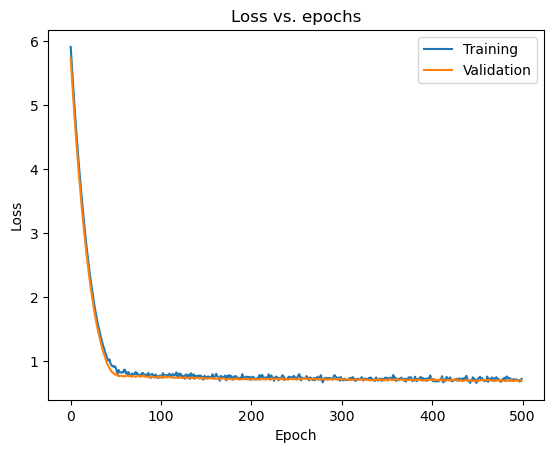

In [25]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history_regularised.history['loss'])
plt.plot(history_regularised.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
# 03 Batch normalization

***
<a id="coding_tutorial_3"></a>
# 04 Introduction to callbacks

Callbacks are special functions that are executed during training at certain stages, such as at the end of an epoch or before/after a batch is processed. They allow you to customize and extend the training process in various ways, such as monitoring metrics, saving models, adjusting learning rates, and implementing early stopping.

Callbacks are implemented as classes that inherit from the `tf.keras.callbacks.Callback` base class. You can create your own custom callbacks by defining methods that correspond to different stages of the training process, such as `on_epoch_begin`, `on_epoch_end`, `on_batch_begin`, and `on_batch_end`.

Callbacks can be passed to the `fit` method of a Keras model using the `callbacks` argument, which accepts a list of callback instances.

Callbacks are useful for tasks such as:
- Monitoring training progress and metrics
- Saving model checkpoints
- Adjusting learning rates dynamically
- Implementing early stopping to prevent overfitting

Callbacks provide a flexible way to enhance and control the training process in TensorFlow/Keras.
https://www.tensorflow.org/guide/keras/custom_callback?hl=es-419

#### Example training callback

In [26]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self, logs=None):
        print("Starting training!")

    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch+1}...")

    def on_train_batch_begin(self, batch, logs=None):
        print(f"  Starting batch {batch+1}...")
    
    def on_train_batch_end(self, batch, logs=None):
        print(f"  Finished batch {batch+1}.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch+1}. Loss: {logs.get('loss')}, Val Loss: {logs.get('val_loss')}")

    def on_train_end(self, logs=None):
        print("Finished training!")

In [27]:
# Re-build the model

model_with_callback = get_model_with_regularisation()

/home/nvidia/miniforge3/envs/rapids-25.10-cuda12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
# Compile the model

compile_(model_with_callback)

#### Train the model with the callback

In [29]:
# Train the model, with some of the data reserved for validation

model_with_callback.fit(
    data_train,
    targets_train,
    validation_split=0.2,
    epochs=5,  # Reduced epochs for brevity
    batch_size=64,
    verbose=0,
    callbacks=[TrainingCallback()]
)

Starting training!
Starting epoch 1...
  Starting batch 1...
  Finished batch 1.
  Starting batch 2...
  Finished batch 2.
  Starting batch 3...
  Finished batch 3.
  Starting batch 4...
  Finished batch 4.
  Starting batch 5...
  Finished batch 5.
Finished epoch 1. Loss: 5.935297966003418, Val Loss: 5.749415397644043
Starting epoch 2...
  Starting batch 1...
  Finished batch 1.
  Starting batch 2...
  Finished batch 2.
  Starting batch 3...
  Finished batch 3.
  Starting batch 4...
  Finished batch 4.
  Starting batch 5...
  Finished batch 5.
Finished epoch 2. Loss: 5.700727939605713, Val Loss: 5.520627975463867
Starting epoch 3...
  Starting batch 1...
  Finished batch 1.
  Starting batch 2...
  Finished batch 2.
  Starting batch 3...
  Finished batch 3.
  Starting batch 4...
  Finished batch 4.
  Starting batch 5...
  Finished batch 5.
Finished epoch 3. Loss: 5.477081775665283, Val Loss: 5.297776222229004
Starting epoch 4...
  Starting batch 1...
  Finished batch 1.
  Starting batch

In [32]:
# Write a custom callback

class TestingCallback(Callback):
    
    def on_test_begin(self, logs=None):
        print("Starting testing!")

    def on_test_batch_begin(self, batch, logs=None):
        print(f"  Starting batch {batch+1}...")
    
    def on_test_batch_end(self, batch, logs=None):
        print(f"  Finished batch {batch+1}.")

    def on_test_end(self, logs=None):
        print("Finished testing!")

In [33]:
# Evaluate the model

model_with_callback.evaluate(
    data_test,
    targets_test,
    verbose=0,
    callbacks=[TestingCallback()]
)

Starting testing!
  Starting batch 1...
  Finished batch 1.
  Starting batch 2...
  Finished batch 2.
Finished testing!


[4.789398670196533, 0.790574312210083, 0.837498128414154]

In [34]:
# Write a custom callback

class PredictionCallback(Callback):
    
    def on_predict_begin(self, logs=None):
        print("Starting predicting!")

    def on_predict_batch_begin(self, batch, logs=None):
        print(f"  Starting batch {batch+1}...")
    
    def on_predict_batch_end(self, batch, logs=None):
        print(f"  Finished batch {batch+1}.")

    def on_predict_end(self, logs=None):
        print("Finished predicting!")

In [35]:
# Make predictions with the model

model_with_callback.predict(
    data_test,
    batch_size=64,
    verbose=0,
    callbacks=[PredictionCallback()]
)

Starting predicting!
  Starting batch 1...


2025-11-26 19:49:53.407458: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-26 19:49:54.235040: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 1112 bytes spill stores, 1112 bytes spill loads



  Finished batch 1.
Finished predicting!


array([[ 0.02409625],
       [ 0.01987817],
       [-0.03268437],
       [ 0.02186444],
       [-0.05727078],
       [ 0.01556707],
       [-0.02752504],
       [ 0.00912517],
       [ 0.01248526],
       [ 0.03314685],
       [ 0.01512382],
       [-0.01581994],
       [-0.0492839 ],
       [-0.01409906],
       [-0.05837148],
       [ 0.04807813],
       [ 0.04799144],
       [-0.05433642],
       [ 0.00949182],
       [-0.0545764 ],
       [ 0.04714414],
       [-0.05838025],
       [-0.0269598 ],
       [-0.03846093],
       [-0.00551837],
       [-0.01590004],
       [ 0.03040817],
       [-0.03009246],
       [-0.02181292],
       [ 0.01497063],
       [ 0.00972498],
       [ 0.07711407],
       [ 0.02677765],
       [ 0.00955649],
       [-0.02682414],
       [ 0.02831111],
       [-0.05079524],
       [-0.04224516],
       [ 0.03530438],
       [ 0.01100651],
       [-0.04724193],
       [-0.01006252],
       [-0.01728733],
       [ 0.02935009],
       [ 0.01616669]], dtype=flo

***
<a id="coding_tutorial_99"></a>
# 05 Using logs dictionary in callbacks

***
<a id="coding_tutorial_4"></a>
# 06 Early stopping / patience

Early stopping is a regularisation technique used to prevent overfitting during the training of machine learning models, particularly neural networks. The idea behind early stopping is to monitor the model's performance on a validation set during training and to halt the training process when the performance on the validation set starts to degrade, indicating that the model is beginning to overfit the training data. It can also be seen as a form of model selection, where the best model is chosen based on its performance on a validation set rather than solely on the training set, and it is a callback function that can be used during training to automatically stop the training process when a specified metric (e.g., validation loss or accuracy) stops improving for a certain number of epochs (patience).

#### Re-train the models with early stopping

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

In [83]:
# Declare an early stopping callback that monitors validation mse, if it doesn't improve for 10 epochs for at least 0.0001, stop training and restore best weights

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001,
    restore_best_weights=True
)

# we need to declare it again 
early_stopping2 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001,
    restore_best_weights=True
)

In [84]:
# Re-train the unregularised model

unregularised_model = get_model()
compile_(unregularised_model)
unreg_history = unregularised_model.fit(
    data_train,
    targets_train,
    validation_split=0.2,
    epochs=500,
    batch_size=64,
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/500


/home/nvidia/miniforge3/envs/rapids-25.10-cuda12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 - 3s - 651ms/step - loss: 1.0177 - mae: 0.8546 - mse: 1.0177 - val_loss: 0.9664 - val_mae: 0.8596 - val_mse: 0.9664
Epoch 2/500
5/5 - 0s - 31ms/step - loss: 0.9994 - mae: 0.8464 - mse: 0.9994 - val_loss: 0.9465 - val_mae: 0.8501 - val_mse: 0.9465
Epoch 3/500
5/5 - 0s - 29ms/step - loss: 0.9758 - mae: 0.8353 - mse: 0.9758 - val_loss: 0.9152 - val_mae: 0.8354 - val_mse: 0.9152
Epoch 4/500
5/5 - 0s - 30ms/step - loss: 0.9433 - mae: 0.8212 - mse: 0.9433 - val_loss: 0.8688 - val_mae: 0.8131 - val_mse: 0.8688
Epoch 5/500
5/5 - 0s - 24ms/step - loss: 0.8946 - mae: 0.8008 - mse: 0.8946 - val_loss: 0.8097 - val_mae: 0.7841 - val_mse: 0.8097
Epoch 6/500
5/5 - 0s - 24ms/step - loss: 0.8336 - mae: 0.7732 - mse: 0.8336 - val_loss: 0.7418 - val_mae: 0.7487 - val_mse: 0.7418
Epoch 7/500
5/5 - 0s - 25ms/step - loss: 0.7630 - mae: 0.7387 - mse: 0.7630 - val_loss: 0.6760 - val_mae: 0.7056 - val_mse: 0.6760
Epoch 8/500
5/5 - 0s - 32ms/step - loss: 0.6916 - mae: 0.7006 - mse: 0.6916 - val_loss: 0.6087

In [85]:
# Evaluate the model on the test set

evaluate_(unregularised_model)

2/2 - 0s - 222ms/step - loss: 0.5442 - mae: 0.5700 - mse: 0.5442
[0.5442059636116028, 0.5699519515037537, 0.5442059636116028]
Test set loss: 0.5442059636116028
Test set MAE: 0.5699519515037537
Test set MSE: 0.5442059636116028


In [86]:
# Re-train the regularised model

regularised_model = get_model_with_regularisation()
compile_(regularised_model)
reg_history = regularised_model.fit(
    data_train,
    targets_train,
    validation_split=0.2,
    epochs=500,
    batch_size=64,
    verbose=2,
    callbacks=[early_stopping2]
)

Epoch 1/500
5/5 - 5s - 1s/step - loss: 5.9586 - mae: 0.8550 - mse: 1.0181 - val_loss: 5.7766 - val_mae: 0.8618 - val_mse: 0.9724
Epoch 2/500
5/5 - 0s - 22ms/step - loss: 5.7289 - mae: 0.8528 - mse: 1.0124 - val_loss: 5.5483 - val_mae: 0.8578 - val_mse: 0.9641
Epoch 3/500
5/5 - 0s - 24ms/step - loss: 5.5046 - mae: 0.8496 - mse: 1.0056 - val_loss: 5.3279 - val_mae: 0.8549 - val_mse: 0.9580
Epoch 4/500
5/5 - 0s - 30ms/step - loss: 5.2843 - mae: 0.8455 - mse: 0.9974 - val_loss: 5.1131 - val_mae: 0.8520 - val_mse: 0.9513
Epoch 5/500
5/5 - 0s - 24ms/step - loss: 5.0793 - mae: 0.8470 - mse: 0.9983 - val_loss: 4.9037 - val_mae: 0.8493 - val_mse: 0.9449
Epoch 6/500
5/5 - 0s - 24ms/step - loss: 4.8716 - mae: 0.8445 - mse: 0.9913 - val_loss: 4.7017 - val_mae: 0.8472 - val_mse: 0.9397
Epoch 7/500
5/5 - 0s - 27ms/step - loss: 4.6721 - mae: 0.8427 - mse: 0.9865 - val_loss: 4.5064 - val_mae: 0.8455 - val_mse: 0.9358
Epoch 8/500
5/5 - 0s - 28ms/step - loss: 4.4818 - mae: 0.8432 - mse: 0.9853 - val_los

In [87]:
# Evaluate the model on the test set

evaluate_(regularised_model)

2/2 - 1s - 322ms/step - loss: 0.8018 - mae: 0.5995 - mse: 0.5537
[0.8018172979354858, 0.5994824171066284, 0.5537245273590088]
Test set loss: 0.8018172979354858
Test set MAE: 0.5994824171066284
Test set MSE: 0.5537245273590088


#### Plot the learning curves

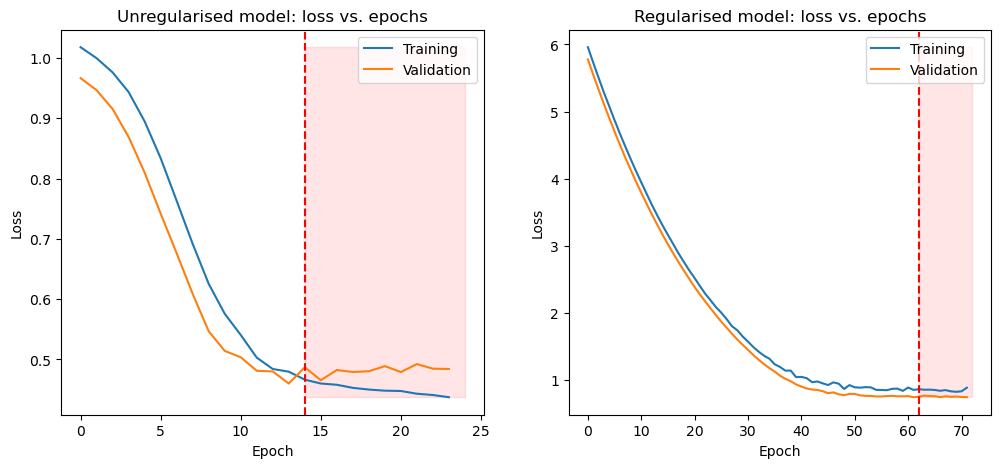

In [96]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.axvline(x=len(unreg_history.history['loss'])-10, color='r', linestyle='--')
plt.fill_betweenx(
    y=[min(min(unreg_history.history['loss']), min(unreg_history.history['val_loss'])), 
       max(max(unreg_history.history['loss']), max(unreg_history.history['val_loss']))],
    x1=len(unreg_history.history['loss'])-10,
    x2=len(unreg_history.history['loss']),
    color='red',
    alpha=0.1
)

plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.axvline(x=len(reg_history.history['loss'])-10, color='r', linestyle='--')
plt.fill_betweenx(
    y=[min(min(reg_history.history['loss']), min(reg_history.history['val_loss'])), 
       max(max(reg_history.history['loss']), max(reg_history.history['val_loss']))],
    x1=len(reg_history.history['loss'])-10,
    x2=len(reg_history.history['loss']),
    color='red',
    alpha=0.1
)

plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

***
# 07 Additional callback arguments